# Plot Visitation Totals

#### Primary Authors:
Chris Carey, Nuoyi Wang

#### Description:
This notebook plots the total food location visitations over time.

#### Inputs:
```
exports/home_weekly.csv
```

#### Visualizations:
> Time-series plot total food location visitations

In [1]:
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pytz

import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from datetime import datetime
import dateutil.tz

import warnings
warnings.filterwarnings('ignore')

In [2]:
FONT_SIZE_TICKS=13
FONT_SIZE_AXIS=14
FONT_SIZE_TITLE=16
FONT_SIZE_LEGEND=14
tzinfo = pytz.timezone('US/Eastern')

In [3]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [33]:
def repair_dates(df, date_column='date_range_start'):
    df[date_column] = pd.to_datetime(df[date_column], utc=True)
    df[date_column] = df[date_column].dt.tz_convert('US/Eastern')

In [36]:
def repair_dt_index(df):
    df = df.sort_values(by=['date_range_start'])
    dt_index = pd.date_range(df.loc[0, 'date_range_start'], df.loc[len(df) - 1, 'date_range_start'], freq='W-MON')
    df = df.set_index('date_range_start')
    df = df.reindex(dt_index)
    return df

In [40]:
def smoothen(df, columns=[], N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_groupby = df.copy()
    rolling_df = rolling_groupby[columns].rolling(N + 1, center=True).mean()
    rolling_df = rolling_df.reset_index()
    rolling_df = rolling_df.sort_values(by=['index'])
    rolling_df = rolling_df.set_index(['index'])
    return rolling_df

In [38]:
home_weekly_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_weekly_df)
home_weekly_df = home_weekly_df.rename(columns={'home_cbg': 'cbg'})
peek(home_weekly_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.250000,0.250000,20.076046
1,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050210021,4,6.697436,0.013158,0.013158,0.509311
2,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360470285021,4,7.414691,0.007273,0.007273,0.563855


27738422


In [41]:
total_df = home_weekly_df.groupby(by=['date_range_start']).agg({
    'visitor_count': 'sum',
    'estimated_visitor_count': 'sum'
}).reset_index()
total_df = repair_dt_index(total_df)
total_df = smoothen(total_df,
                    columns=['visitor_count', 'estimated_visitor_count'])
total_df

,visitor_count,estimated_visitor_count
index,,
2018-12-31 00:00:00-05:00,NaN,NaN
2019-01-07 00:00:00-05:00,1.345694e+06,2.987885e+06
2019-01-14 00:00:00-05:00,1.364274e+06,2.999605e+06
2019-01-21 00:00:00-05:00,1.378141e+06,3.057874e+06
2019-01-28 00:00:00-05:00,1.399974e+06,3.128813e+06
...,...,...
2021-01-18 00:00:00-05:00,5.099867e+05,2.244652e+06
2021-01-25 00:00:00-05:00,4.777530e+05,2.130302e+06
2021-02-01 00:00:00-05:00,4.851440e+05,2.176345e+06


In [42]:
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

def thousands(x, pos):
    return '%1.0fK' % (x * 1e-3)

In [43]:
covid_df = pd.read_csv('./data/cases-by-day.csv')
covid_df = covid_df.rename(columns={
    'CASE_COUNT': 'case_count',
    'date_of_interest': 'date',
})
covid_df = covid_df[['date', 'case_count']]
covid_df['date'] = pd.to_datetime(covid_df['date']).dt.tz_localize('US/Eastern')
covid_df['week'] = covid_df['date'].dt.week
covid_df = covid_df.groupby(by=['week']).agg({
    'date': 'first',
    'case_count': 'sum',
}).reset_index()
covid_df = covid_df.sort_values(by=['date'])
covid_df[['case_count']] = covid_df[['case_count']].rolling(3, center=True).mean()
# Drop first week. It doesn't start on Monday and it's NaN due to rolling average.
covid_df = covid_df.iloc[1:, :]
covid_df = covid_df.set_index('date')

In [44]:
total_and_covid_df = total_df.merge(covid_df, left_index=True, right_index=True, how='outer')
peek(total_and_covid_df)

,visitor_count,estimated_visitor_count,week,case_count
2018-12-31 00:00:00-05:00,NaN,NaN,NaN,NaN
2019-01-07 00:00:00-05:00,1.345694e+06,2.987885e+06,NaN,NaN
2019-01-14 00:00:00-05:00,1.364274e+06,2.999605e+06,NaN,NaN


113


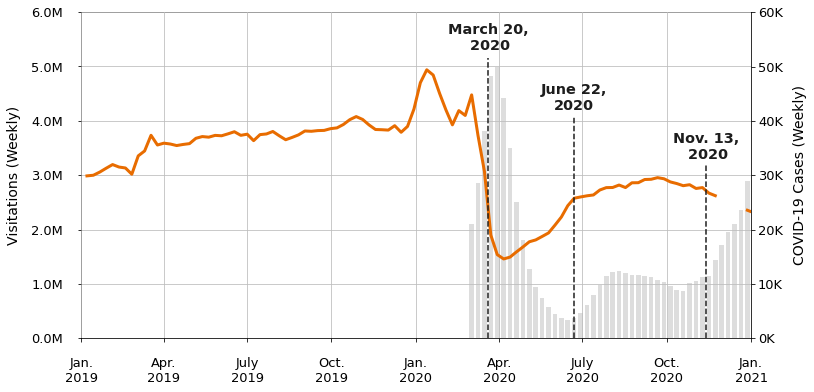

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
bar_ax = ax.twinx()

bar_ax.bar(total_and_covid_df.index, total_and_covid_df['case_count'], width=5, color='#ddd')

ax.plot(total_and_covid_df.index, total_and_covid_df['estimated_visitor_count'], linewidth=3, color='#e86c00')

ax.set_zorder(1)
ax.set_frame_on(False)

ax.axvline('2020-03-20', 0, 0.86, color='#1d1d1d', linestyle='dashed')
ax.text('2020-03-20',
         5.3e6,
         "March 20,\n 2020",
         horizontalalignment='center',
         size='x-large',
         color='#1d1d1d',
         weight='semibold')

ax.axvline('2020-06-22', 0, 0.68, color='#1d1d1d', linestyle='dashed')
ax.text('2020-06-22',
         4.2e6,
         "June 22,\n2020",
         horizontalalignment='center',
         size='x-large',
         color='#1d1d1d',
         weight='semibold')

ax.axvline('2020-11-13', 0, 0.53, color='#1d1d1d', linestyle='dashed')
ax.text('2020-11-13',
         3.3e6,
         "Nov. 13,\n 2020",
         horizontalalignment='center',
         size='x-large',
         color='#1d1d1d',
         weight='semibold')

m_formatter = FuncFormatter(millions)
k_formatter = FuncFormatter(thousands)

ax.set_xlabel('')
ax.set_ylabel('Visitations (Weekly)', fontsize=FONT_SIZE_AXIS, labelpad=10)

bar_ax.set_ylabel('COVID-19 Cases (Weekly)', fontsize=FONT_SIZE_AXIS, labelpad=10)

ax.yaxis.set_major_formatter(m_formatter)
bar_ax.yaxis.set_major_formatter(k_formatter)

ax.xaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)
ax.yaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)
bar_ax.yaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)

ax.set_facecolor('#ffffff')
ax.grid(color='#bdbdbd')
ax.set_ylim([0, 6000000])
ax.set_xlim([
    datetime(2019, 1, 1, 0, 0, tzinfo=tzinfo),
    datetime(2021, 1, 1, 1, 0, tzinfo=tzinfo)
])
bar_ax.set_ylim([0, 60000])
plt.setp(ax.spines.values(), color='#000000')
ax.tick_params(axis='x', which='major', pad=15)
ax.tick_params(axis='y', which='major', pad=15)
ax.set_xticklabels([
    'Jan.\n2019',
    'Apr.\n2019',
    'July\n2019',
    'Oct.\n2019',
    'Jan.\n2020',
    'Apr.\n2020',
    'July\n2020',
    'Oct.\n2020',
    'Jan.\n2021',
],
                   rotation=0,
                   ha='center')
plt.show()